## GOES-16 Snow Cover Routine
First attempt based on the suggestion in this document:
https://www.goes-r.gov/education/docs/ABI-bands-FS/ABI_Band%205_snow-ice_factsheet_FINAL.pdf

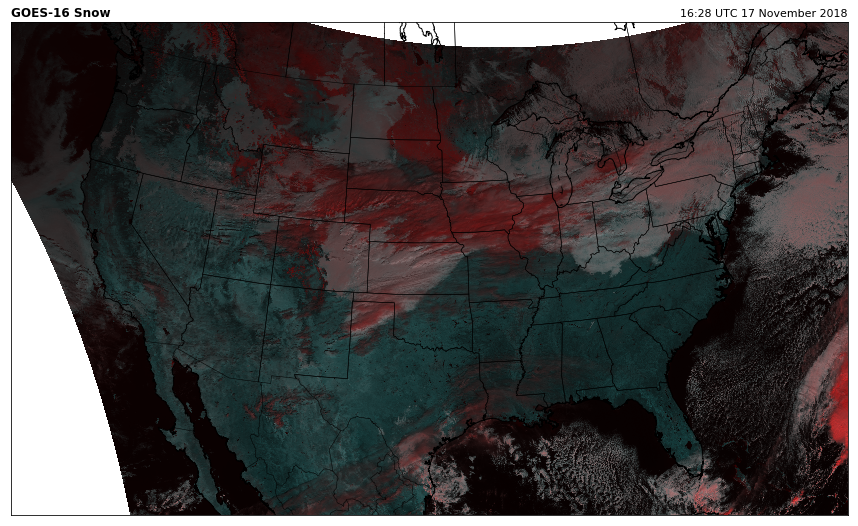

In [135]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj

# Read netcdf file
C_file = '/home/kschneider/Downloads/OR_ABI-L2-MCMIPC-M3_G16_s20183211627149_e20183211629522_c20183211630029.nc'
C = Dataset(C_file, 'r')

# Get date and time
add_seconds = C.variables['t'][0] # Number of seconds since year 2000
add_seconds=int(add_seconds)
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Load the RGB arrays
R = C.variables['CMI_C02'][:]
G = C.variables['CMI_C05'][:]
B = C.variables['CMI_C05'][:]

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R=np.clip(R, 0, 1)
G=np.clip(G, 0, 1)
B=np.clip(B, 0, 1)

# Satellite height, lon, sweep
sat_h = C.variables['goes_imager_projection'].perspective_point_height
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

# using the Proj library to generate map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

# Make a new map object for CONUS Lambert Conformal Conic Projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)


# Create a color tuple for pcolormesh
RGB = np.dstack([R,G,B])
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster, according to stackoverflow. Not sure why.

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Snow', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()


Problem: We see snow cover, but cirrus is also identified as "snow". I used the 'cirrus band' to create a mask to get rid of the cirrus. 

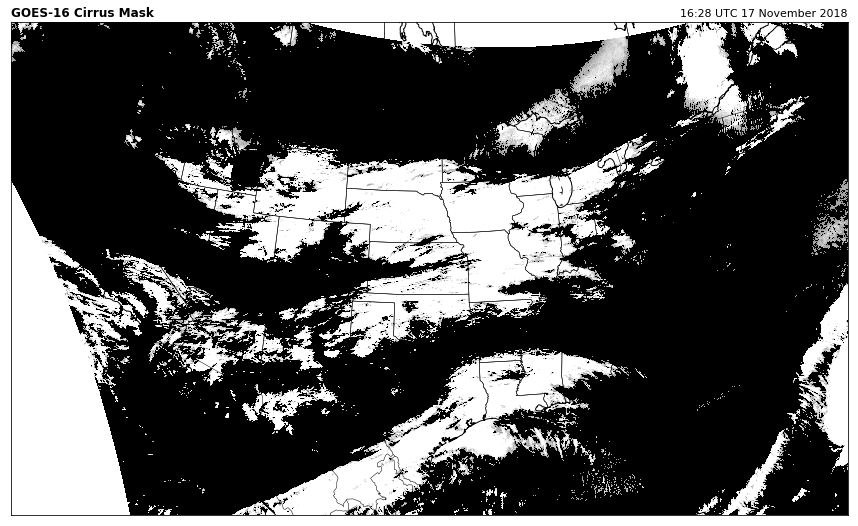

In [182]:
# Cirrus
CI = C.variables['CMI_C04'][:]

CI = np.clip(CI, 0, 0.02) # An arbitrary threshold 
CI[CI<0.01] = 0

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, CI, cmap='Greys_r', linewidth=0, latlon=True)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Cirrus Mask', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()


Now, subtracting the cirrus mask from the visible band to create a new red channel gives a much cleaner image.

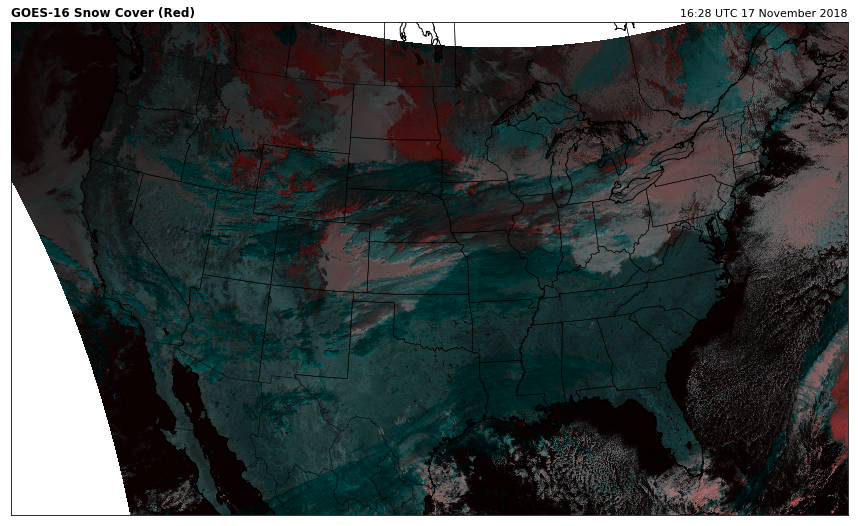

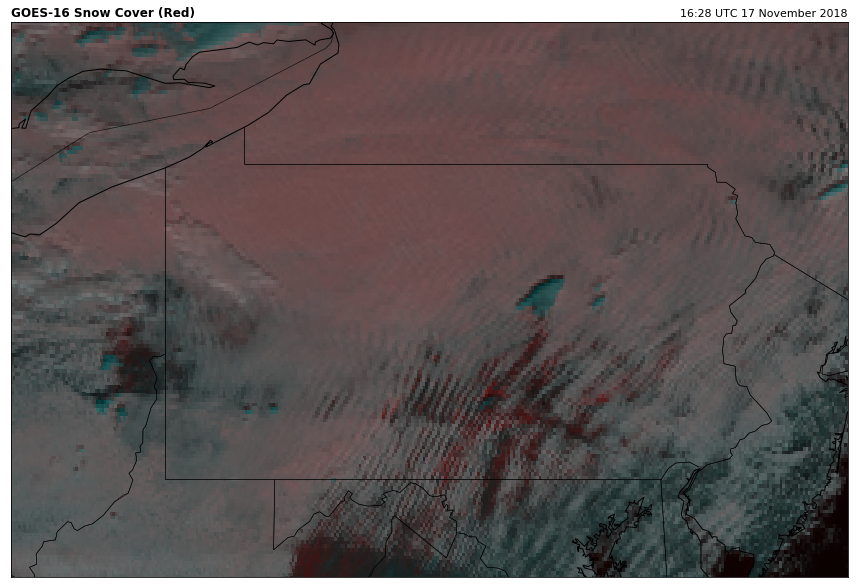

In [181]:
R = VIS - CI*10. # Applying the cirrus mask to the red channel
# Apply range limits for each channel becuase RGB values must be between 0 and 1
R=np.clip(R, 0, 1)
G=np.clip(G, 0, 1)
B=np.clip(B, 0, 1)

# Plot the image
plt.figure(figsize=[15,12])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
#newmap = mH.pcolormesh(lons, lats, R, cmap='Greys_r', linewidth=0, latlon=True)
mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 Snow Cover (Red)', fontweight='semibold', fontsize=12, loc='left')
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), fontsize=11, loc='right')
plt.show()

# PA Sub-Section
mZ = Basemap(resolution='i', projection='merc', area_thresh=5000,\
             llcrnrlon=-82., llcrnrlat=39.,\
             urcrnrlon=-74., urcrnrlat=43.,lon_0=-77,lat_0=40.5)

plt.figure(figsize=[15,12])
newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
mZ.drawcoastlines()
mZ.drawcountries()
mZ.drawstates()
plt.title('GOES-16 Snow Cover (Red)', loc='left', fontweight='semibold', fontsize=12)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right', fontsize=11)

Here's a 4-panel graphic illustrating the various components of the snow cover product:

Text(0.5,0.98,'GOES-16 Snow Cover 4-Panel')

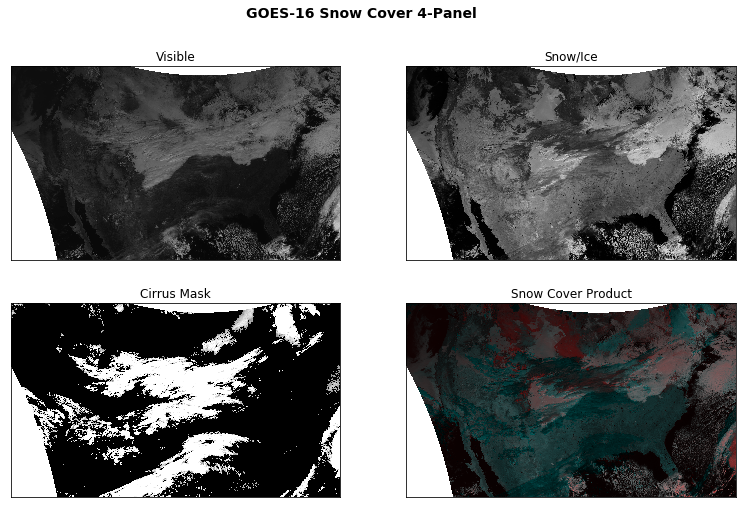

In [183]:
fig = plt.figure(figsize=[13,8])

# Visible
ax = fig.add_subplot(221)
newmap = mH.pcolormesh(lons, lats, VIS, cmap='Greys_r', linewidth=0, latlon=True)
ax.set_title('Visible')

# Snow/Ice
ax = fig.add_subplot(222)
newmap = mH.pcolormesh(lons, lats, G, cmap='Greys_r', linewidth=0, latlon=True)
ax.set_title('Snow/Ice')

# Cirrus Mask
ax = fig.add_subplot(223)
newmap = mH.pcolormesh(lons, lats, CI, cmap='Greys_r', linewidth=0, latlon=True)
ax.set_title('Cirrus Mask')

# Snow Cover Product
ax = fig.add_subplot(224)
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None)
ax.set_title('Snow Cover Product')

plt.suptitle('GOES-16 Snow Cover 4-Panel', fontweight='semibold', fontsize=14)